Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


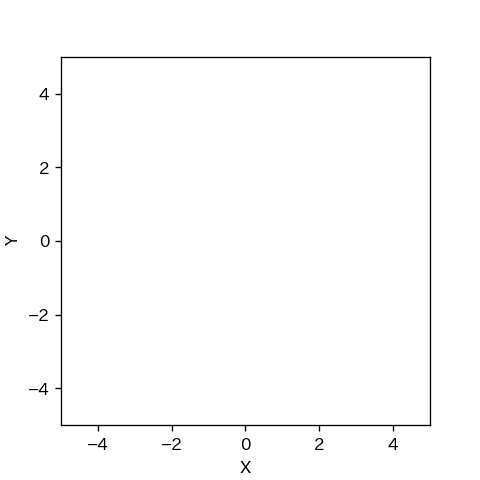

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

<IPython.core.display.Javascript object>


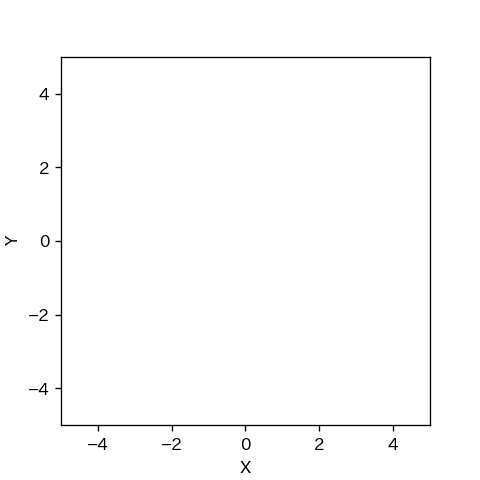

(array([ 2.46093611, -3.50475684, -0.84933234]),
 array([-2.9111356 ,  1.63012173, -0.78862314]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [ 4.42403857 -1.85366098  3.71757962] 推定値: [ 4.2477909  -1.7230202   3.74066979] 誤差: 0.21938608677951493
1
[4.4155735717436615]
1 真値: [-3.96225374 -3.11985215  3.9038392 ] 推定値: [-1.53544275 -1.88162904  4.41806382] 誤差: 2.72444638487825
[2.8363371891715063]
2 真値: [-5.57890143e+00 -3.28669804e-03  4.81317905e+00] 推定値: [-2.53064573  4.0225768   1.71049333] 誤差: 5.049696991963998
[1.7436956446025218]
3 真値: [ 2.87004101 -0.26537841  7.22398975] 推定値: [3.19561524 0.15329536 7.46969028] 誤差: 0.5303643138547774
2
4 真値: [-4.72510665  4.0952813   4.64483638] 推定値: [-4.62142415  4.19371079  4.5535824 ] 誤差: 0.14296302133580416
3
[3.854674930378819]
5 真値: [-0.09568246  2.17801439  6.33047988] 推定値: [-0.13869013  2.63788761  6.11586271] 誤差: 0.4618798965498176
4
[4.949387075888259]
6 真値: [-2.00710978 -1.92628717  3.59880685] 推定値: [-1.87694461 -2.24509466  3.78548453] 誤差: 0.344356191411461
5
7 真値: [-3.73131147 -0.33104018  7.5301359 ] 推定値: [-1.8137712   2.83127132  2.98074546] 誤差: 3.6982664526942357


C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.3980466914733998]
[3.603351230107133]
[4.643668403781906]
20 真値: [ 4.89932107 -0.50822193  8.13079502] 推定値: [ 2.08282156  7.56397943 -1.53695345] 誤差: 8.549450534587427
[5.763976145409158]
21 真値: [4.91808115 4.27403179 2.30764465] 推定値: [4.80636365 3.74686726 2.41594165] 誤差: 0.5388721986869351
16
22 真値: [-0.9322973  -4.00808297  8.68828245] 推定値: [-0.888525   -3.13266838  8.23385677] 誤差: 0.876508257274378
17
[5.787522732372331]
23 真値: [4.73502713 3.26833716 2.913108  ] 推定値: [4.73641087 2.80548008 2.55953961] 誤差: 0.46285914932319816
18
[5.354786425667781]
24 真値: [-0.25415396 -2.24652785  6.99420278] 推定値: [-0.27206285 -2.34568392  6.9799396 ] 誤差: 0.10076037365291075
19
[3.9047511310825658]
[4.384260110310711]
25 真値: [5.06326589 0.41905958 2.12855017] 推定値: [ 6.24050308  4.14388616 -2.97158312] 誤差: 3.906433208478163
[4.894718734913221, 7.268288133757218]
26 真値: [-1.31677288  2.08604412  2.08923083] 推定値: [-1.76497623  1.22972821  2.87904821] 誤差: 0.9665211776926087
20
27 真値: [3.75717196 0.10